# Installing CuPy

Follow their [docs](https://docs.cupy.dev/en/stable/install.html) to install

For myself I installed cuda-toolkit 12.8.1 through conda and then pip installed `cupy-cuda12x`

## Verify Install

In [1]:
import numpy as np
import cupy as cp

In [2]:
x_cpu = np.array([1, 2, 3])
l2_cpu = np.linalg.norm(x_cpu)

In [3]:
x_gpu = cp.array([1, 2, 3])
l2_gpu = cp.linalg.norm(x_gpu)

# Benchmark Test

In [4]:
import numpy as np
import cupy as cp
import time
import matplotlib.pyplot as plt

def benchmark_operation(operation_name, numpy_func, cupy_func, sizes):
    """
    Benchmark a specific operation across different data sizes.
    
    Args:
        operation_name: Name of the operation
        numpy_func: Function that performs the operation with NumPy
        cupy_func: Function that performs the operation with CuPy
        sizes: List of data sizes to test
    
    Returns:
        Dictionary with timing results
    """
    results = {
        'sizes': sizes,
        'numpy_times': [],
        'cupy_times': [],
        'speedup': []
    }
    
    print(f"\n{'='*60}")
    print(f"Benchmarking: {operation_name}")
    print(f"{'='*60}")
    print(f"{'Size':<15} {'NumPy (ms)':<15} {'CuPy (ms)':<15} {'Speedup (x times faster)':<15}")
    print(f"{'-'*60}")
    
    for size in sizes:
        # NumPy timing
        start = time.time()
        _ = numpy_func(size)
        numpy_time = (time.time() - start) * 1000  # Convert to milliseconds
        
        # CuPy timing (with warm-up)
        _ = cupy_func(size)  # Warm-up run
        cp.cuda.Stream.null.synchronize()  # Wait for GPU to finish
        
        start = time.time()
        _ = cupy_func(size)
        cp.cuda.Stream.null.synchronize()  # Wait for GPU to finish
        cupy_time = (time.time() - start) * 1000  # Convert to milliseconds
        
        speedup = numpy_time / cupy_time
        if cupy_time > numpy_time:
            speedup *= -1
        
        results['numpy_times'].append(numpy_time)
        results['cupy_times'].append(cupy_time)
        results['speedup'].append(speedup)
        
        print(f"{size:<15} {numpy_time:<15.2f} {cupy_time:<15.2f} {speedup:<15.2f}")
    
    return results


# Define benchmark operations
def matrix_multiply_numpy(size):
    a = np.random.rand(size, size).astype(np.float32)
    b = np.random.rand(size, size).astype(np.float32)
    return np.dot(a, b)

def matrix_multiply_cupy(size):
    a = cp.random.rand(size, size, dtype=cp.float32)
    b = cp.random.rand(size, size, dtype=cp.float32)
    return cp.dot(a, b)

def element_wise_numpy(size):
    a = np.random.rand(size, size).astype(np.float32)
    b = np.random.rand(size, size).astype(np.float32)
    return a * b + np.sin(a) + np.cos(b)

def element_wise_cupy(size):
    a = cp.random.rand(size, size, dtype=cp.float32)
    b = cp.random.rand(size, size, dtype=cp.float32)
    return a * b + cp.sin(a) + cp.cos(b)

def reduction_numpy(size):
    a = np.random.rand(size, size).astype(np.float32)
    return np.sum(a), np.mean(a), np.std(a)

def reduction_cupy(size):
    a = cp.random.rand(size, size, dtype=cp.float32)
    return cp.sum(a), cp.mean(a), cp.std(a)

In [5]:
# Test with different sizes
sizes = [100, 500, 1000, 5000, 10_000]

# Run different benchmarks
results_matmul = benchmark_operation(
    "Matrix Multiplication (NxN x NxN)",
    matrix_multiply_numpy,
    matrix_multiply_cupy,
    sizes
)

results_elementwise = benchmark_operation(
    "Element-wise Operations (a*b + sin(a) + cos(b))",
    element_wise_numpy,
    element_wise_cupy,
    sizes
)

results_reduction = benchmark_operation(
    "Reduction Operations (sum, mean, std)",
    reduction_numpy,
    reduction_cupy,
    sizes
)


Benchmarking: Matrix Multiplication (NxN x NxN)
Size            NumPy (ms)      CuPy (ms)       Speedup (x times faster)
------------------------------------------------------------
100             0.86            0.19            4.50           
500             4.07            0.14            29.89          
1000            9.94            0.15            66.74          
5000            331.01          4.18            79.23          
10000           2067.90         32.92           62.82          

Benchmarking: Element-wise Operations (a*b + sin(a) + cos(b))
Size            NumPy (ms)      CuPy (ms)       Speedup (x times faster)
------------------------------------------------------------
100             0.11            0.17            -0.61          
500             3.21            0.06            54.76          
1000            10.27           0.06            168.26         
5000            287.14          1.30            221.64         
10000           1133.63         5.27        


PERFORMANCE SUMMARY

Average Speedups (CuPy vs NumPy):
  • Matrix Multiplication:  48.6x faster
  • Element-wise Ops:       131.9x faster
  • Reduction Ops:          5.7x faster

Maximum Speedup Achieved:   221.6x

Benchmark complete! Graph saved as 'cupy_vs_numpy_benchmark.png'


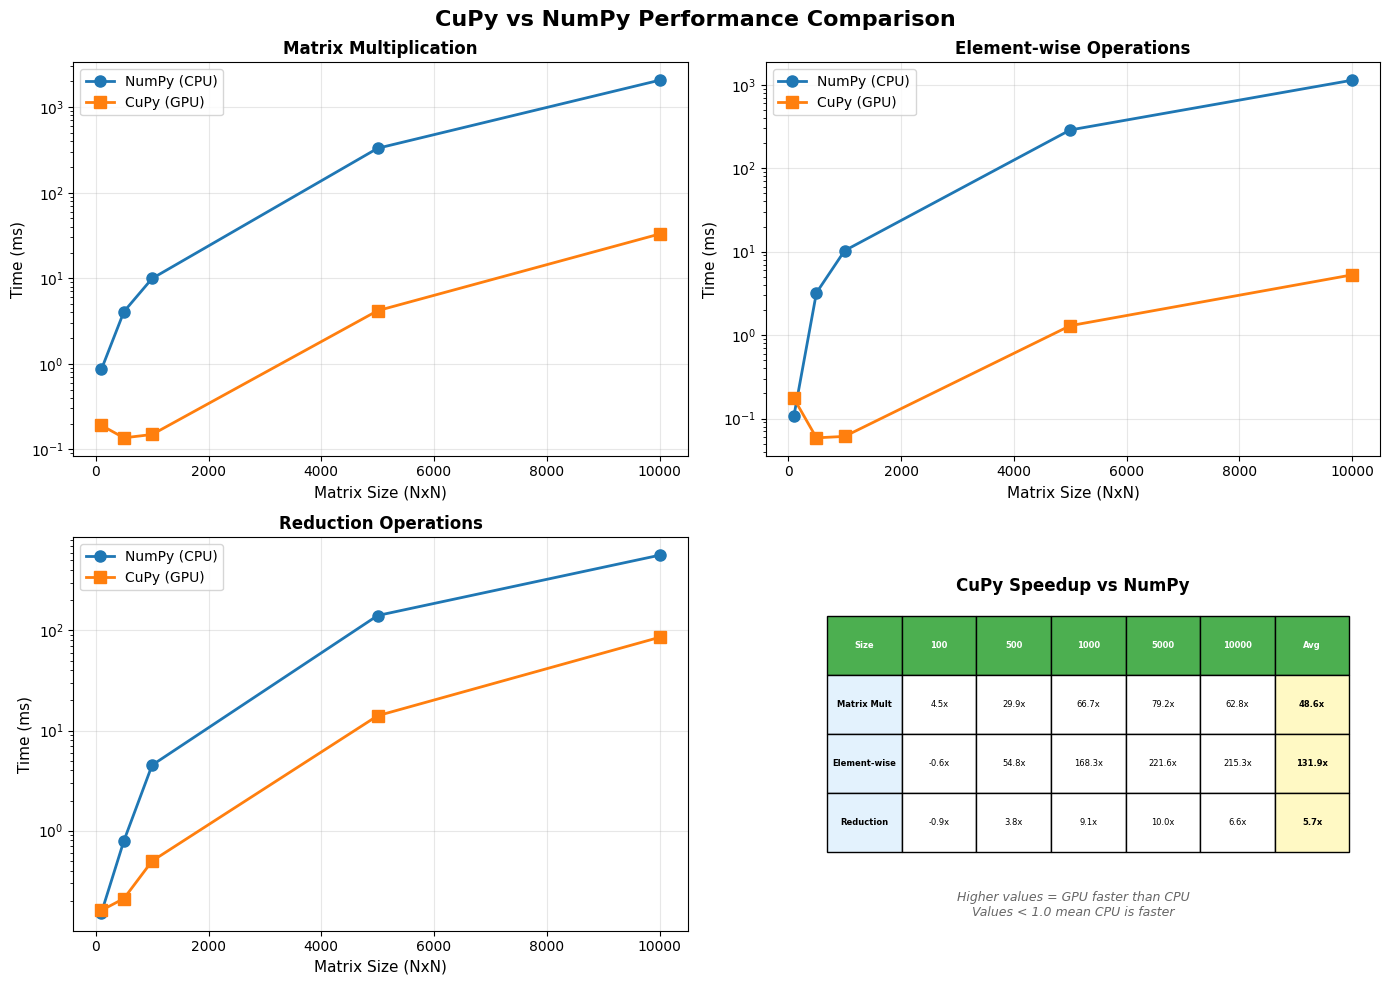

In [6]:
# Plot results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('CuPy vs NumPy Performance Comparison', fontsize=16, fontweight='bold')

# Plot 1: Matrix Multiplication Time
ax1 = axes[0, 0]
ax1.plot(results_matmul['sizes'], results_matmul['numpy_times'], 
            'o-', label='NumPy (CPU)', linewidth=2, markersize=8)
ax1.plot(results_matmul['sizes'], results_matmul['cupy_times'], 
            's-', label='CuPy (GPU)', linewidth=2, markersize=8)
ax1.set_xlabel('Matrix Size (NxN)', fontsize=11)
ax1.set_ylabel('Time (ms)', fontsize=11)
ax1.set_title('Matrix Multiplication', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# Plot 2: Element-wise Operations Time
ax2 = axes[0, 1]
ax2.plot(results_elementwise['sizes'], results_elementwise['numpy_times'], 
            'o-', label='NumPy (CPU)', linewidth=2, markersize=8)
ax2.plot(results_elementwise['sizes'], results_elementwise['cupy_times'], 
            's-', label='CuPy (GPU)', linewidth=2, markersize=8)
ax2.set_xlabel('Matrix Size (NxN)', fontsize=11)
ax2.set_ylabel('Time (ms)', fontsize=11)
ax2.set_title('Element-wise Operations', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_yscale('log')

# Plot 3: Reduction Operations Time (NEW LINE PLOT)
ax3 = axes[1, 0]
ax3.plot(results_reduction['sizes'], results_reduction['numpy_times'], 
            'o-', label='NumPy (CPU)', linewidth=2, markersize=8, color='#1f77b4')
ax3.plot(results_reduction['sizes'], results_reduction['cupy_times'], 
            's-', label='CuPy (GPU)', linewidth=2, markersize=8, color='#ff7f0e')
ax3.set_xlabel('Matrix Size (NxN)', fontsize=11)
ax3.set_ylabel('Time (ms)', fontsize=11)
ax3.set_title('Reduction Operations', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_yscale('log')

# Plot 4: Speedup Comparison Table
ax4 = axes[1, 1]
ax4.axis('off')

# Prepare table data
table_data = []
table_data.append(['Size'] + [str(s) for s in sizes])
table_data.append(['Matrix Mult'] + [f'{s:.1f}x' for s in results_matmul['speedup']])
table_data.append(['Element-wise'] + [f'{s:.1f}x' for s in results_elementwise['speedup']])
table_data.append(['Reduction'] + [f'{s:.1f}x' for s in results_reduction['speedup']])

# Calculate averages for the last column
avg_matmul = np.mean(results_matmul['speedup'])
avg_elementwise = np.mean(results_elementwise['speedup'])
avg_reduction = np.mean(results_reduction['speedup'])

# Add average column
for i, row in enumerate(table_data):
    if i == 0:
        row.append('Avg')
    elif i == 1:
        row.append(f'{avg_matmul:.1f}x')
    elif i == 2:
        row.append(f'{avg_elementwise:.1f}x')
    elif i == 3:
        row.append(f'{avg_reduction:.1f}x')

# Create table
table = ax4.table(cellText=table_data, 
                    cellLoc='center',
                    loc='center',
                    bbox=[0.1, 0.2, 0.85, 0.6])

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(6)
table.scale(1, 2.5)

# Color header row
for i in range(len(table_data[0])):
    cell = table[(0, i)]
    cell.set_facecolor('#4CAF50')
    cell.set_text_props(weight='bold', color='white')

# Color operation names (first column)
for i in range(1, len(table_data)):
    cell = table[(i, 0)]
    cell.set_facecolor('#E3F2FD')
    cell.set_text_props(weight='bold')

# Color average column
for i in range(len(table_data)):
    cell = table[(i, len(table_data[0])-1)]
    if i == 0:
        cell.set_facecolor('#4CAF50')
    else:
        cell.set_facecolor('#FFF9C4')
        cell.set_text_props(weight='bold')

# Add title above table
ax4.text(0.5, 0.9, 'CuPy Speedup vs NumPy', 
            ha='center', va='top', fontsize=12, fontweight='bold',
            transform=ax4.transAxes)

# Add note below table
note_text = "Higher values = GPU faster than CPU\nValues < 1.0 mean CPU is faster"
ax4.text(0.5, 0.1, note_text, 
            ha='center', va='top', fontsize=9, style='italic',
            transform=ax4.transAxes, color='#666666')

plt.tight_layout()
plt.savefig('cupy_vs_numpy_benchmark.png', dpi=300, bbox_inches='tight')

# Print summary statistics
avg_speedup_matmul = np.mean(results_matmul['speedup'])
avg_speedup_elementwise = np.mean(results_elementwise['speedup'])
avg_speedup_reduction = np.mean(results_reduction['speedup'])
max_speedup = max(max(results_matmul['speedup']), 
                    max(results_elementwise['speedup']),
                    max(results_reduction['speedup']))

print("\n" + "="*60)
print("PERFORMANCE SUMMARY")
print("="*60)
print(f"\nAverage Speedups (CuPy vs NumPy):")
print(f"  • Matrix Multiplication:  {avg_speedup_matmul:.1f}x faster")
print(f"  • Element-wise Ops:       {avg_speedup_elementwise:.1f}x faster")
print(f"  • Reduction Ops:          {avg_speedup_reduction:.1f}x faster")
print(f"\nMaximum Speedup Achieved:   {max_speedup:.1f}x")
print("\n" + "="*60)
print("Benchmark complete! Graph saved as 'cupy_vs_numpy_benchmark.png'")
print("="*60)
plt.show()

# Scipy vs CuPy

In [7]:
import numpy as np
import cupy as cp
import scipy
import cupyx
import time
import matplotlib.pyplot as plt

from scipy import linalg as sp_linalg, fft as sp_fft, sparse as sp_sparse
from cupyx.scipy import fft as cp_fft, sparse as cp_sparse

def benchmark_operation(operation_name, scipy_func, cupy_func, sizes):
    """
    Benchmark a specific operation across different data sizes.

    Args:
        operation_name: Name of the operation
        scipy_func: Function using SciPy (CPU)
        cupy_func: Function using CuPy / cupyx.scipy (GPU)
        sizes: List of problem sizes to test
    """
    results = {'sizes': sizes, 'scipy_times': [], 'cupy_times': [], 'speedup': []}

    print(f"\n{'='*70}")
    print(f"Benchmarking: {operation_name}")
    print(f"{'='*70}")
    print(f"{'Size':<15} {'SciPy (ms)':<15} {'CuPy (ms)':<15} {'Speedup (x times faster)':<15}")
    print(f"{'-'*70}")

    for size in sizes:
        # CPU timing
        start = time.time()
        _ = scipy_func(size)
        scipy_time = (time.time() - start) * 1000  # ms

        # GPU timing (warm-up + sync)
        _ = cupy_func(size)
        cp.cuda.Stream.null.synchronize()
        start = time.time()
        _ = cupy_func(size)
        cp.cuda.Stream.null.synchronize()
        cupy_time = (time.time() - start) * 1000  # ms

        speedup = scipy_time / cupy_time
        if cupy_time > scipy_time:
            speedup *= -1
        results['scipy_times'].append(scipy_time)
        results['cupy_times'].append(cupy_time)
        results['speedup'].append(speedup)

        print(f"{size:<15} {scipy_time:<15.2f} {cupy_time:<15.2f} {speedup:<15.2f}")

    return results

def scipy_fft(size):
    x = np.random.rand(size, size).astype(np.float32)
    return sp_fft.fft2(x)

def cupy_fft(size):
    x = cp.random.rand(size, size, dtype=cp.float32)
    return cp_fft.fft2(x)

def scipy_linalg_solve(size):
    X = np.random.rand(size, size).astype(np.float32)
    A = X.T @ X + np.eye(size, dtype=np.float32)
    b = np.random.rand(size).astype(np.float32)
    return sp_linalg.solve(A, b, assume_a='pos')

def cupy_linalg_solve(size):
    X = cp.random.rand(size, size, dtype=cp.float32)
    A = X.T @ X + cp.eye(size, dtype=cp.float32)
    b = cp.random.rand(size, dtype=cp.float32)
    return cp.linalg.solve(A, b)

def scipy_sparse_matmul(size):
    A = sp_sparse.random(size, size, density=0.01, format='csr', dtype=np.float32)
    B = sp_sparse.random(size, size, density=0.01, format='csr', dtype=np.float32)
    return A @ B

def cupy_sparse_matmul(size):
    A = cp_sparse.random(size, size, density=0.01, format='csr', dtype=cp.float32)
    B = cp_sparse.random(size, size, density=0.01, format='csr', dtype=cp.float32)
    return A @ B

def scipy_svd(size):
    X = np.random.rand(size, size).astype(np.float32)
    return sp_linalg.svd(X, full_matrices=False)

def cupy_svd(size):
    X = cp.random.rand(size, size, dtype=cp.float32)
    return cp.linalg.svd(X, full_matrices=False)

sizes = [100, 500, 512, 1024, 2048]

results_fft = benchmark_operation("FFT 2D", scipy_fft, cupy_fft, sizes)
results_solve = benchmark_operation("Linear Solve (A x = b)", scipy_linalg_solve, cupy_linalg_solve, sizes)
results_sparse = benchmark_operation("Sparse Matrix Multiply", scipy_sparse_matmul, cupy_sparse_matmul, sizes)
results_svd = benchmark_operation("Singular Value Decomposition", scipy_svd, cupy_svd, sizes)



Benchmarking: FFT 2D
Size            SciPy (ms)      CuPy (ms)       Speedup (x times faster)
----------------------------------------------------------------------
100             0.24            0.11            2.11           
500             1.34            0.09            15.00          
512             1.77            0.07            23.90          
1024            8.17            0.09            86.12          
2048            38.33           0.15            262.27         

Benchmarking: Linear Solve (A x = b)
Size            SciPy (ms)      CuPy (ms)       Speedup (x times faster)
----------------------------------------------------------------------
100             0.53            0.39            1.36           
500             3.61            0.99            3.63           
512             2.57            0.96            2.68           
1024            105.51          2.00            52.79          
2048            171.70          4.84            35.48          

Benchmarkin


PERFORMANCE SUMMARY

Average Speedups (CuPy vs SciPy):
  • FFT 2D:              77.9x
  • Linear Solve:        19.2x
  • Sparse Matrix Mult:  6.2x
  • SVD:                 15.4x

Note: Speedup > 1.0 means GPU is faster
      Speedup < 1.0 means CPU is faster (usually small data)

Benchmark complete! Graph saved as 'scipy_vs_cupy_benchmark.png'


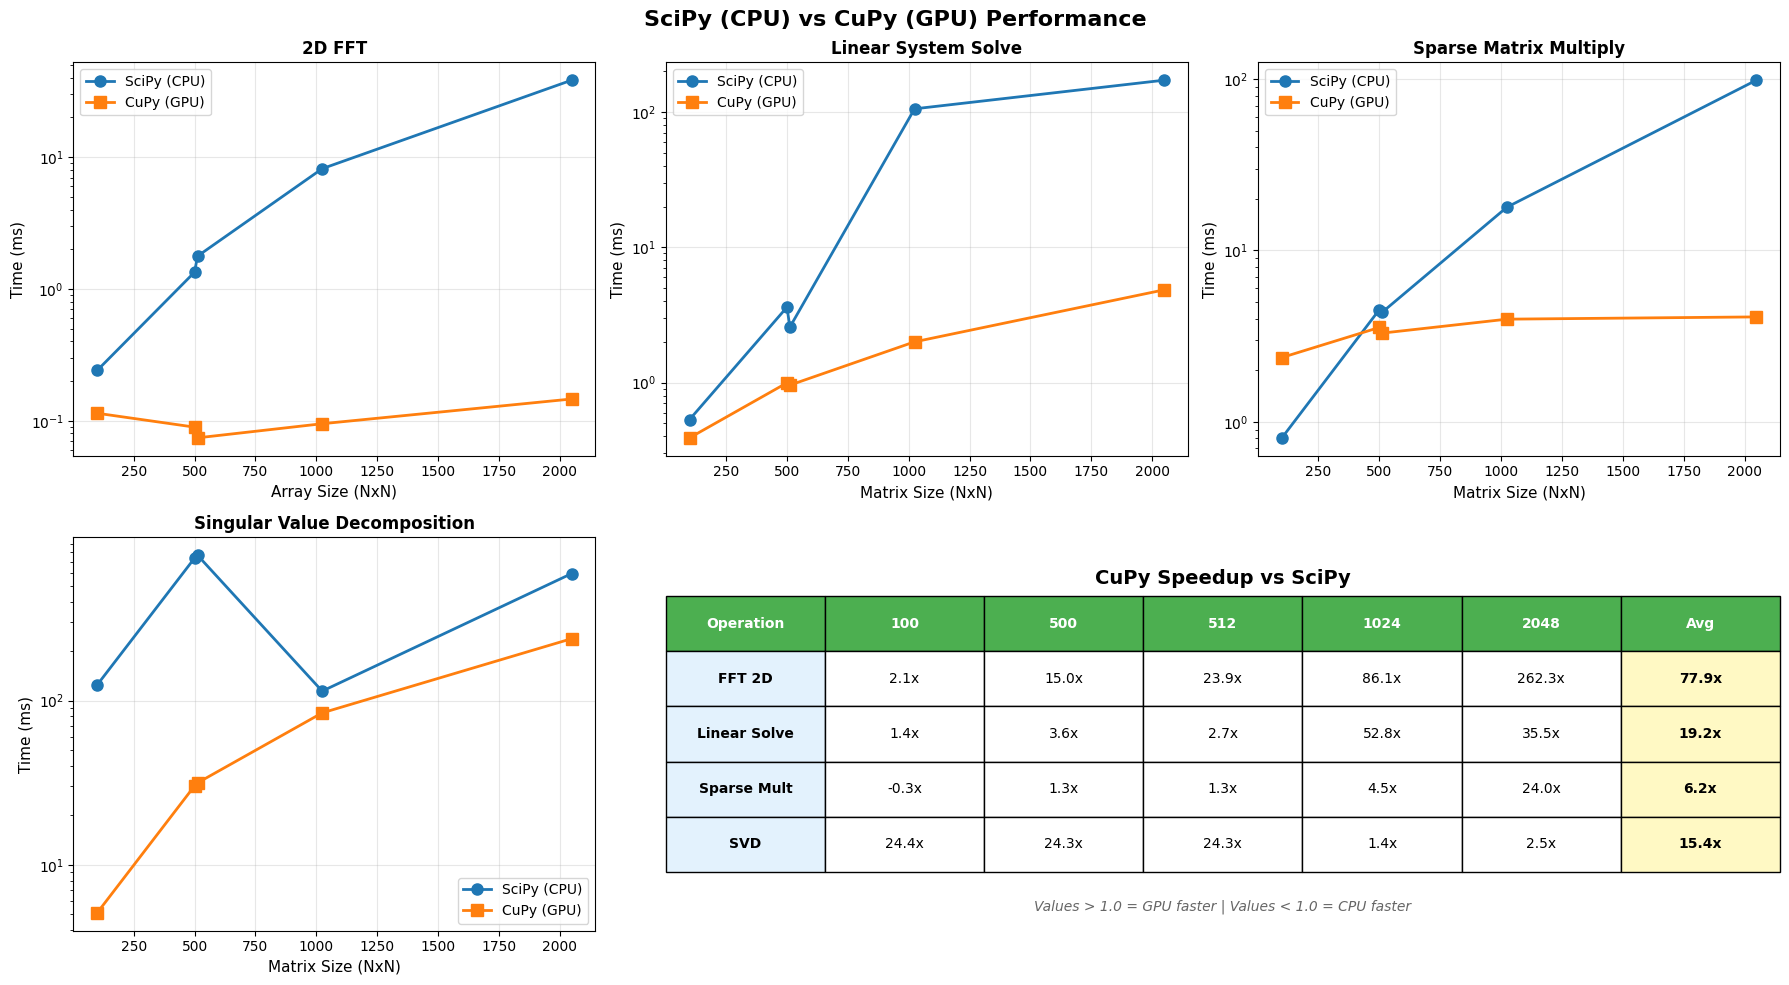

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('SciPy (CPU) vs CuPy (GPU) Performance', fontsize=16, fontweight='bold')

ax1 = axes[0, 0]
ax1.plot(results_fft['sizes'], results_fft['scipy_times'], 
         'o-', label='SciPy (CPU)', linewidth=2, markersize=8)
ax1.plot(results_fft['sizes'], results_fft['cupy_times'], 
         's-', label='CuPy (GPU)', linewidth=2, markersize=8)
ax1.set_xlabel('Array Size (NxN)', fontsize=11)
ax1.set_ylabel('Time (ms)', fontsize=11)
ax1.set_title('2D FFT', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

ax2 = axes[0, 1]
ax2.plot(results_solve['sizes'], results_solve['scipy_times'], 
         'o-', label='SciPy (CPU)', linewidth=2, markersize=8)
ax2.plot(results_solve['sizes'], results_solve['cupy_times'], 
         's-', label='CuPy (GPU)', linewidth=2, markersize=8)
ax2.set_xlabel('Matrix Size (NxN)', fontsize=11)
ax2.set_ylabel('Time (ms)', fontsize=11)
ax2.set_title('Linear System Solve', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_yscale('log')

ax3 = axes[0, 2]
ax3.plot(results_sparse['sizes'], results_sparse['scipy_times'], 
         'o-', label='SciPy (CPU)', linewidth=2, markersize=8)
ax3.plot(results_sparse['sizes'], results_sparse['cupy_times'], 
         's-', label='CuPy (GPU)', linewidth=2, markersize=8)
ax3.set_xlabel('Matrix Size (NxN)', fontsize=11)
ax3.set_ylabel('Time (ms)', fontsize=11)
ax3.set_title('Sparse Matrix Multiply', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_yscale('log')

ax4 = axes[1, 0]
ax4.plot(results_svd['sizes'], results_svd['scipy_times'], 
         'o-', label='SciPy (CPU)', linewidth=2, markersize=8, color='#1f77b4')
ax4.plot(results_svd['sizes'], results_svd['cupy_times'], 
         's-', label='CuPy (GPU)', linewidth=2, markersize=8, color='#ff7f0e')
ax4.set_xlabel('Matrix Size (NxN)', fontsize=11)
ax4.set_ylabel('Time (ms)', fontsize=11)
ax4.set_title('Singular Value Decomposition', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_yscale('log')

axes[1, 1].set_visible(False)
axes[1, 2].set_visible(False)

ax5 = plt.subplot(2, 3, (5, 6))
ax5.axis('off')

table_data = []
table_data.append(['Operation', '100', '500', '512', '1024', '2048', 'Avg'])

fft_avg = np.mean(results_fft['speedup'])
table_data.append(['FFT 2D'] + [f'{s:.1f}x' for s in results_fft['speedup']] + [f'{fft_avg:.1f}x'])

solve_avg = np.mean(results_solve['speedup'])
table_data.append(['Linear Solve'] + [f'{s:.1f}x' for s in results_solve['speedup']] + [f'{solve_avg:.1f}x'])

sparse_avg = np.mean(results_sparse['speedup'])
table_data.append(['Sparse Mult'] + [f'{s:.1f}x' for s in results_sparse['speedup']] + [f'{sparse_avg:.1f}x'])

svd_avg = np.mean(results_svd['speedup'])
table_data.append(['SVD'] + [f'{s:.1f}x' for s in results_svd['speedup']] + [f'{svd_avg:.1f}x'])

table = ax5.table(cellText=table_data, 
                  cellLoc='center',
                  loc='center',
                  bbox=[0.0, 0.15, 1.0, 0.7])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 3)

for i in range(len(table_data[0])):
    cell = table[(0, i)]
    cell.set_facecolor('#4CAF50')
    cell.set_text_props(weight='bold', color='white')

for i in range(1, len(table_data)):
    cell = table[(i, 0)]
    cell.set_facecolor('#E3F2FD')
    cell.set_text_props(weight='bold')

for i in range(len(table_data)):
    cell = table[(i, len(table_data[0])-1)]
    if i == 0:
        cell.set_facecolor('#4CAF50')
    else:
        cell.set_facecolor('#FFF9C4')
        cell.set_text_props(weight='bold')

ax5.text(0.5, 0.92, 'CuPy Speedup vs SciPy', 
         ha='center', va='top', fontsize=14, fontweight='bold',
         transform=ax5.transAxes)

note_text = "Values > 1.0 = GPU faster | Values < 1.0 = CPU faster"
ax5.text(0.5, 0.08, note_text, 
         ha='center', va='top', fontsize=10, style='italic',
         transform=ax5.transAxes, color='#666666')

plt.tight_layout()
plt.savefig('scipy_vs_cupy_benchmark.png', dpi=300, bbox_inches='tight')

print("\n" + "="*70)
print("PERFORMANCE SUMMARY")
print("="*70)
print(f"\nAverage Speedups (CuPy vs SciPy):")
print(f"  • FFT 2D:              {fft_avg:.1f}x")
print(f"  • Linear Solve:        {solve_avg:.1f}x")
print(f"  • Sparse Matrix Mult:  {sparse_avg:.1f}x")
print(f"  • SVD:                 {svd_avg:.1f}x")
print("\nNote: Speedup > 1.0 means GPU is faster")
print("      Speedup < 1.0 means CPU is faster (usually small data)")
print("\n" + "="*70)
print("Benchmark complete! Graph saved as 'scipy_vs_cupy_benchmark.png'")
print("="*70)

plt.show()